https://www.kaggle.com/c/titanic/data<br>
https://kaggle-kr.tistory.com/17?category=868316

# 타이타닉 튜토리얼 1 - Exploratory data analysis, visualization, machine learning

* 만약 데이터 사이언스, 머신러닝 또는 캐글에서 어떤 것을 해야하는 지 잘 모르는 newbie 라면, 타이타닉을 하시는 게 가장 좋은 선택입니다.
* 타이타닉은 아시다시피, 사상 최대 해난사고로써, 1,500여명의 희생자가 생겼습니다.
* 우리는 이 튜토리얼에서 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것입니다.
* 본 튜토리얼에서는 여러 시각화 도구(matplotlib, seaborn, plotly), 데이터 분석 도구(pandas, numpy), 머신 러닝 도구(sklearn)을 사용할 것입니다.
* 본 튜토리얼은 캐글에 있는 여러 커널들을 참조하여 만들었습니다. 본 튜토리얼을 공부하신 뒤에, 캐글 타이타닉 컴퍼티션에 존재하는 여러 다른 커널들을 더 공부하시면 됩니다.
* 본 튜토리얼은 파이썬 문법에 어려움이 없으셔야 수월할 것입니다. 여기서 사용하는 라이브러리들을 써본 경험이 있으면 좋겠지만, 경험이 없다하더라도 한 줄씩 천천히 적어나가시면 충분히 하실 수 있습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 항상쓰기! matplotlib의 기본 scheme 말고 seaborn scheme을 세팅하고 font_scale 지정하면 편리.
plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

프로세스

1. **데이터셋 확인** - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 _null data_ 가 존재합니다. 이를 확인하고, 향후 수정합니다.  
2. **탐색적 데이터 분석(exploratory data analysis)** - 여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인합니다. 여러 _시각화 툴_을 사용하여 insight를 얻습니다. 
3. **feature engineering** - 모델을 세우기에 앞서, 모델의 성능을 높일수 있도록 feature들을 engeenering합니다. _one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리_ 등을 합니다.
4. **model 만들기** - `sklearn`을 사용해 모델을 만듭니다. <br>파이썬에서 머신러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있습니다.
5. **모델 학습 및 예측** - train set을 가지고 모델을 학습시킨 후, test set을 가지고 prediction합니다.
6. **모델 평가** - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는지 확인해봅시다. 

## Dataset 확인

* 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 `pandas`입니다. 
* 우리는 pandas를 사용하여 데이터셋의 간단한 통계적 분석부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있습니다. 
* 파이썬으로 데이터분석을 한다고 하면 반드시 능숙해져야 할 라이브러리니, 여러 커널들을 공부하시면서 사용법에 익숙해지도록 반복 또 반복하시길 권장합니다. 
* 캐글에서 데이터셋은 보통 train, test set으로 나눠져 있습니다. 

In [2]:
df_train = pd.read_csv('.//titanic//train.csv')
df_test = pd.read_csv('.//titanic//test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


우리가 다루는 문제에서 feature는 Plcass, Sex, Age, SibSp, Parch, Fare 이며 예측하려는 target label은 Survived 입니다. 

| 변수(fature,variable)  | 정의  | 설명  | 타입 |
|---|---|---|---|
| survival  |  생존여부 | target label. 1,0으로 표현  | int  |
| Pclass  | 티켓의 클래스  | 1=1st, 2=2nd, 3=3rd. categorical feature  |  int |
| Sex | 성별 | male,female로 구분되며 binary | string |
| Age | 나이 | continuous | int |
| sibSp | 함께 탑승한 형제와 배우자의 수 | quantitative | int |
| parch | 함께 탑승한 부모, 아이의 수 | quantitative | int |
| ticket | 티켓 번호 | alphabat + integer | int |
| fare | 탑승료 | continuous | float |
| cabin | 객실 번호 | alphabat + integer | int |
| embared | 탑승 항구 | C=Cherbourg, Q=Queenstown, S=Southampton | string |

In [4]:
# pandas의 describe() 메소드는 각 feature의 기술 통계 값을 반환해줍니다. 
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


PassengerID의 count값보다 작은 값을 가지는 열(feature) 은 null data가 존재하는 것 같습니다. 


이를 좀 더 보기 편하도록 그래프로 시각화하여 살펴봅시다. 

### Null data check

In [6]:
for col in df_train.columns :
    msg = 'column : {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column : PassengerId	 Percent of NaN value: 0.00%
column :   Survived	 Percent of NaN value: 0.00%
column :     Pclass	 Percent of NaN value: 0.00%
column :       Name	 Percent of NaN value: 0.00%
column :        Sex	 Percent of NaN value: 0.00%
column :        Age	 Percent of NaN value: 19.87%
column :      SibSp	 Percent of NaN value: 0.00%
column :      Parch	 Percent of NaN value: 0.00%
column :     Ticket	 Percent of NaN value: 0.00%
column :       Fare	 Percent of NaN value: 0.00%
column :      Cabin	 Percent of NaN value: 77.10%
column :   Embarked	 Percent of NaN value: 0.22%


**서식 지정자로 문자열 정렬하기**

`{인덱스:<길이}'.format(값)` <br>
: 인덱스 뒤에 :(콜론)을 붙이고 정렬할 방향과 길이를 지정해주면 됩니다.<br>
`'{:<10}`은 부등호 방향이 왼쪽을 가리키고 있죠? 그래서 문자열을 지정된 길이로 만든 뒤 왼쪽으로 정렬하고 남는 공간을 공백으로 채웁니다.

> 출처 : 24.2 문자열 서식 지정자와 포매팅 사용하기 https://dojang.io/mod/page/view.php?id=2300 

In [7]:
for col in df_test.columns :
    msg = 'column : {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column : PassengerId	 Percent of NaN value: 0.00%
column :     Pclass	 Percent of NaN value: 0.00%
column :       Name	 Percent of NaN value: 0.00%
column :        Sex	 Percent of NaN value: 0.00%
column :        Age	 Percent of NaN value: 20.57%
column :      SibSp	 Percent of NaN value: 0.00%
column :      Parch	 Percent of NaN value: 0.00%
column :     Ticket	 Percent of NaN value: 0.00%
column :       Fare	 Percent of NaN value: 0.24%
column :      Cabin	 Percent of NaN value: 78.23%
column :   Embarked	 Percent of NaN value: 0.00%


Train,Test set에서 Age(둘다 약 20%), Cabin(둘다 약 80%), Embarked(Train만 0.22%), Fare(Test만 약 0.24%) null data가 존재하는 것을 볼 수 있습니다. 


`MSNO` (missingno) 라는 라이브러리를 사용하면 null data 의 존재를 더 쉽게 볼 수 있습니다. 

<AxesSubplot:>

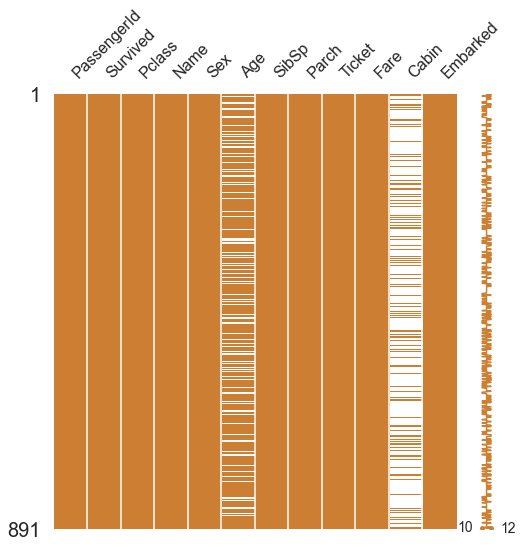

In [8]:
msno.matrix(df=df_train.iloc[:,:], figsize=(8,8), color=(0.8,0.5,0.2))

<AxesSubplot:>

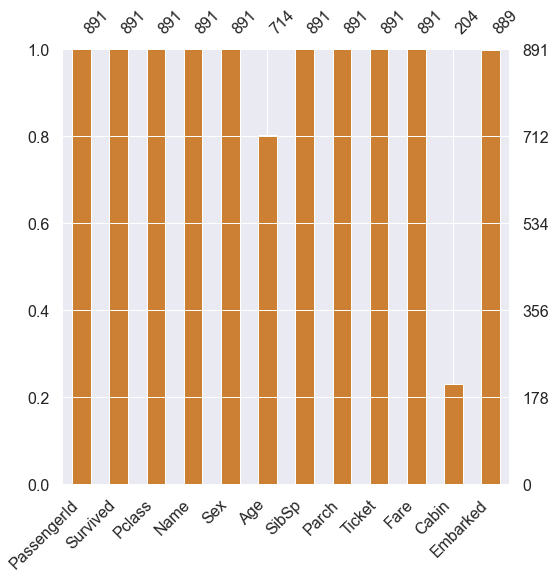

In [9]:
msno.bar(df=df_train,figsize=(8,8), color=(0.8,0.5,0.2))

<AxesSubplot:>

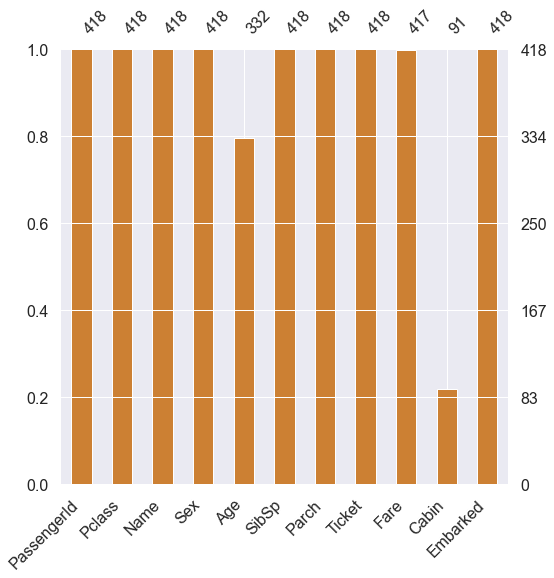

In [10]:
msno.bar(df=df_test,figsize=(8,8), color=(0.8,0.5,0.2))

### Target label 확인

* target label이 어떤 distribution을 가지고 있는지 확인해봐야 합니다. 
* 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있습니다. 

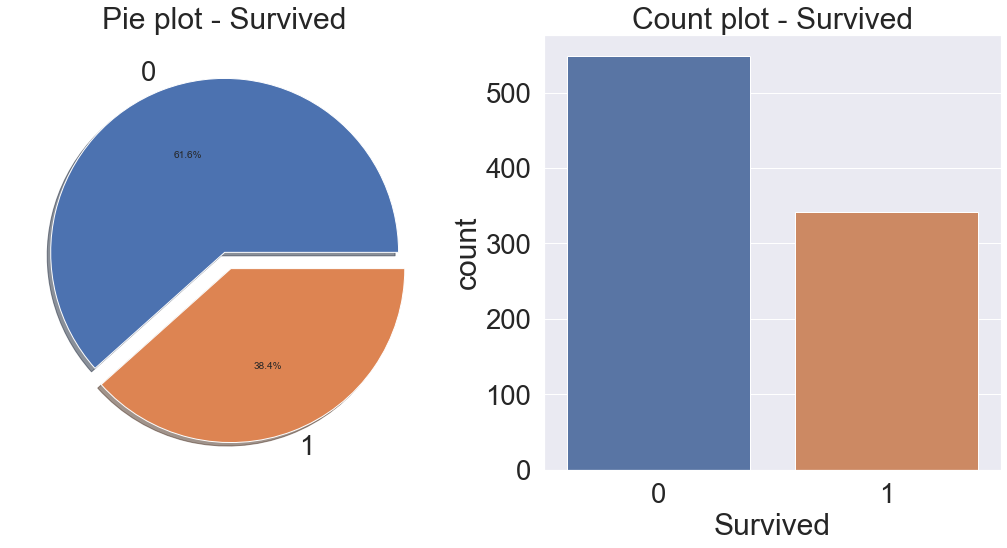

In [11]:
f, ax = plt.subplots(1,2,figsize=(18,8))

# [0] : Pie plot
df_train['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
# [1] : Count plot
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

* 38.4%가 살아남았습니다. 
* target label의 분포가 제법 균일합니다. <br>불균일한 경우, (예를 들어서 100중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라 해도 정확도가 99%가 나오게 됩니다.) 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됩니다.

**pie plot의 parameter**
* autopct : 상대도수를 퍼센트로 표현

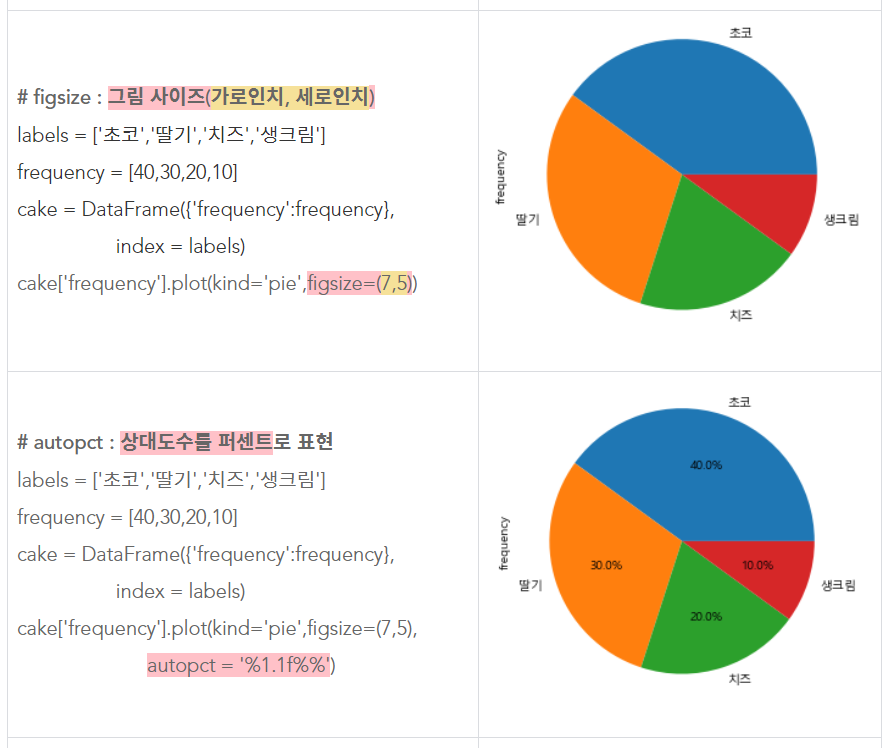


* explode : 조각내기

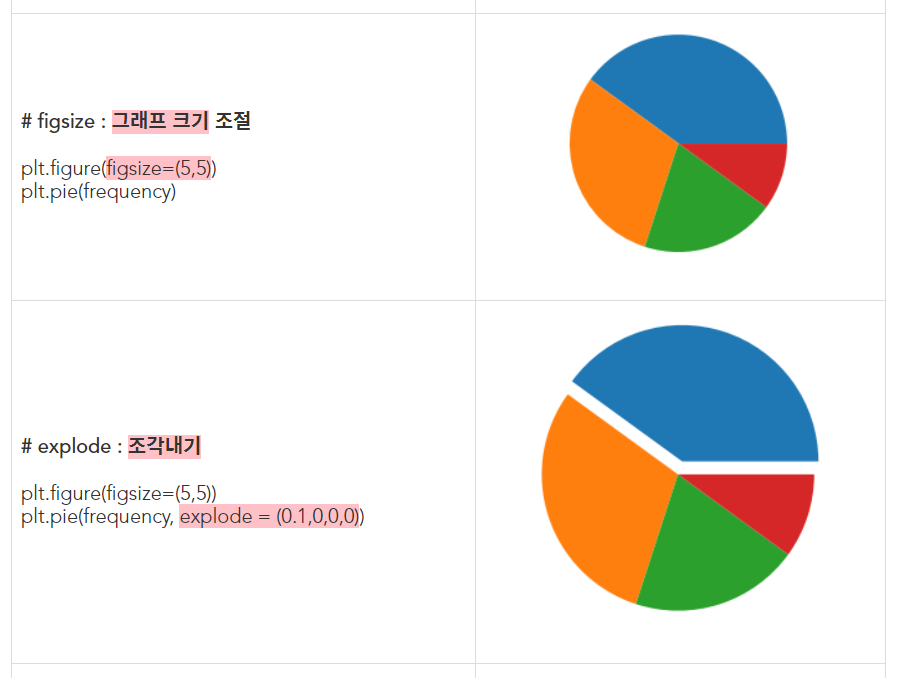
    
> 출처 : https://truman.tistory.com/103

## Exploratory data analysis

* 이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.
* 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다.


### Pclass

* 먼저 Pclass에 대해서 살펴보겠습니다. Pclass는 ordinal, 서수(순서수)형 데이터입니다. 카테고리이면서, 순서가 있는 데이터 타입입니다.
* 먼저 Pclass에 따른 생존률의 차이를 살펴보겠습니다. <br>엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas의 dataframe에서는 `groupby`를 사용하면 쉽게 할 수 있습니다. 또한 `pivot`이라는 매소드도 있습니다. 
* 'Pclass' , 'Survived'를 가져온 후, pclass로 묶습니다. 그러고 나면 각 pclass마다 0 , 1이 count가 되는데, 이를 평균내면 각 pclass별 생존률이 나옵니다.


* 아래와 같이 count( ) 를 하면, 각 class에 몇명이 있는지 확인할 수 있으며, sum( )을 하면 216명 중 생존한(survived=1) 사람의 총합을 주게 됩니다. 


In [12]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index = True).sum()

,Survived
Pclass,
1,136
2,87
3,119


In [14]:
pd.crosstab(df_train['Pclass'],df_train['Survived'],margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [15]:
pd.crosstab(df_train['Pclass'],df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


* grouped객체에 mean()을 하게 되면, 각 클래스별 생존률을 얻을 수 있습니다. class1 이면 아래와 같습니다. 

$$ {136 \over (80 + 136)} \approx 0.63 $$

In [16]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index = True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<AxesSubplot:xlabel='Pclass'>

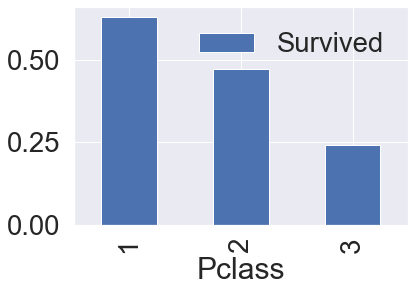

In [17]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index = True).mean().sort_values(by='Survived',ascending=False).plot.bar()

* 보다시피, Pclass가 좋을수록(1st>2nd>3rd) 생존률이 높은 것을 확인할 수 있습니다. 
* 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn의 countplot을 이용하면, 특정 label에 따른 개수를 확인해볼 수 있습니다. 

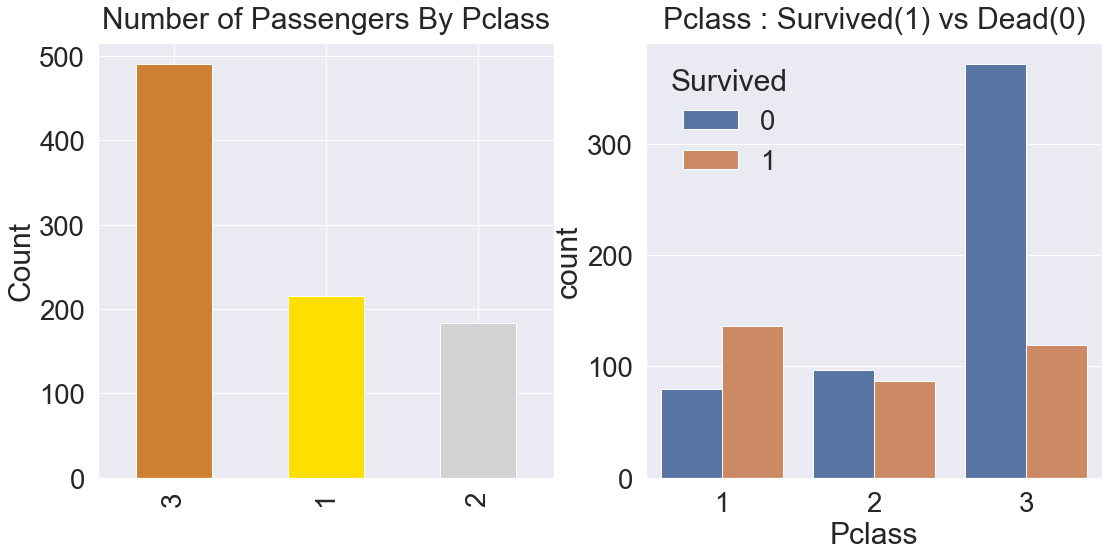

In [22]:
y_position = 1.02 
f , ax = plt.subplots(1, 2, figsize=(18,8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('Pclass : Survived(1) vs Dead(0)', y=y_position)
plt.show()

* 클래스가 높을수록, 생존 확률이 높은걸 확인할 수 있습니다. Pclass 1,2,3의 순서대로 63%,48%,35% 입니다.
* 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feautre를 사용하는 것이 좋을 것이라 판단할 수 있습니다. 

### Sex

* 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보겠습니다. 
* 마찬가지로 `pandas groupby` 와 `seaborn countplot`을 사용해서 시각화해봅시다.


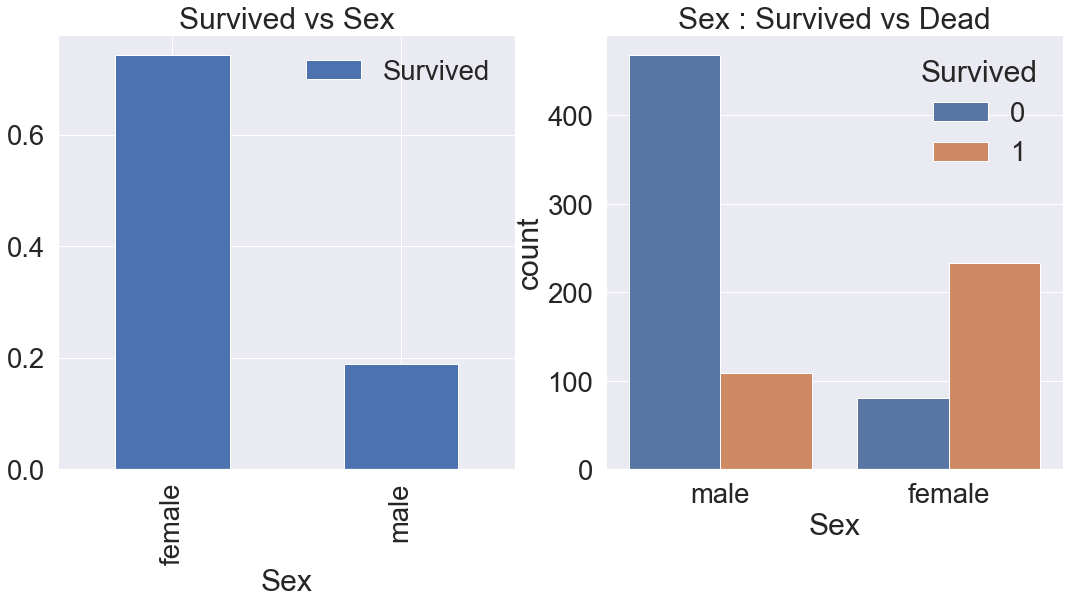

In [23]:
f, ax = plt.subplots(1,2,figsize=(18,8))
df_train[['Sex','Survived']].groupby(['Sex'],as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex : Survived vs Dead')
plt.show()

* 여자가 생존할 확률이 높습니다. 

In [24]:
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [25]:
pd.crosstab(df_train['Sex'], df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


* Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있습니다. 

### Both Sex and Pclass

* 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는지 확인해봅시다.
* seaborn의 `factorplot`을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다. 

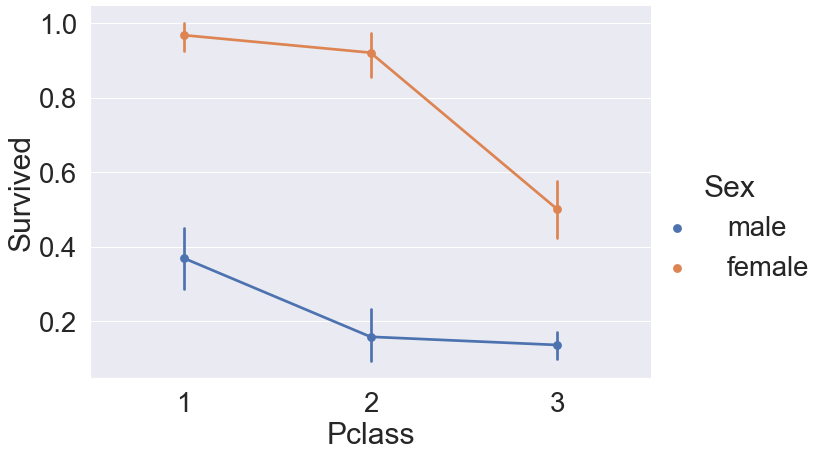

In [27]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df_train, size=6, aspect=1.5)

플롯을 구성 할 때 'size'또는 'aspect'인수를 sns.factorplot ()에 전달하려고합니다.
* `size` 는 가로 세로 비율을 유지하면서 높이를 변경합니다. 따라서 크기 만 변경하면 더 넓어집니다.
* `Aspect` 는 높이를 일정하게 유지하면서 너비를 변경합니다.

* 모든 클래스에서 female이 살 확률이 male보다 높은 걸 알 수 있습니다. 
* 또한, 남자 여자 상관없이 클래스가 높을수록 살 확률이 높아집니다.
* 위 그래프는 hue 대신 column으로 하면 아래와 같아집니다. 

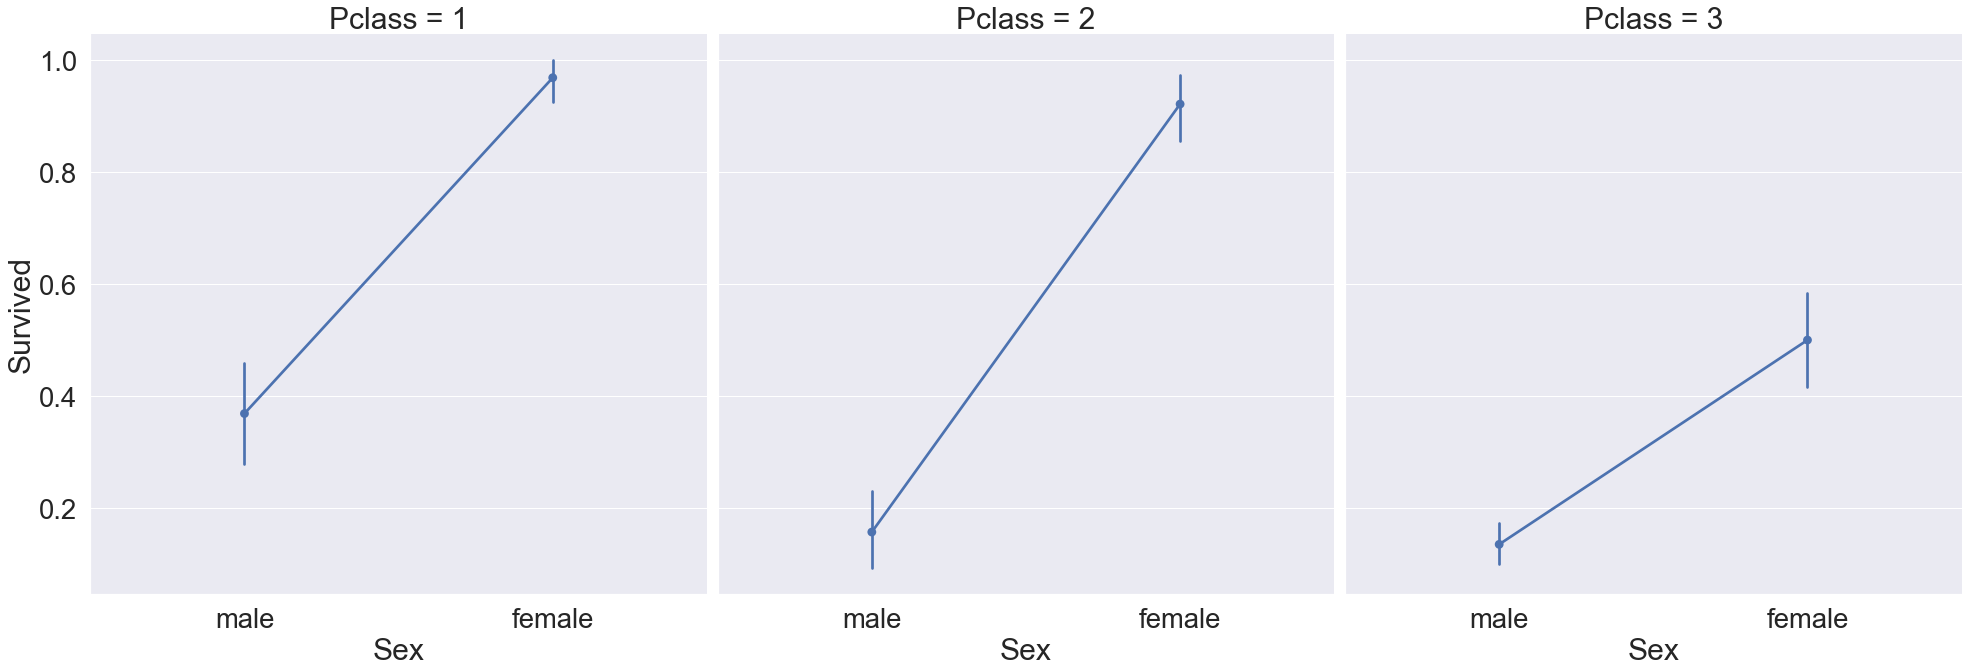

In [34]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, satureation=.5,size=9, aspect=1)

### Age

* 이번에는 Age feature를 살펴봅시다.

In [36]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 나이 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 나이 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


* 생존에 따른 Age의 histogram을 그려보겠습니다.

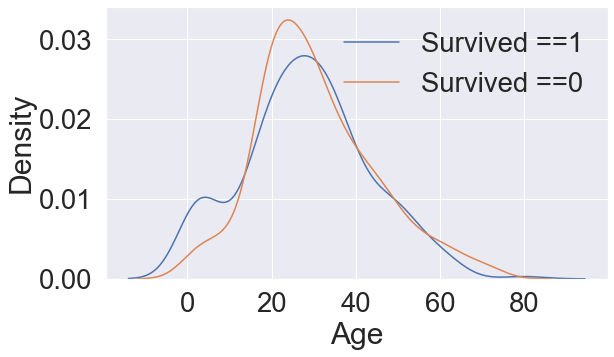

In [38]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax= ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax=ax)
plt.legend(['Survived ==1', 'Survived ==0'])
plt.show()

* 생존자 중 나이가 어린 경우가 많음을 볼 수 있습니다. 

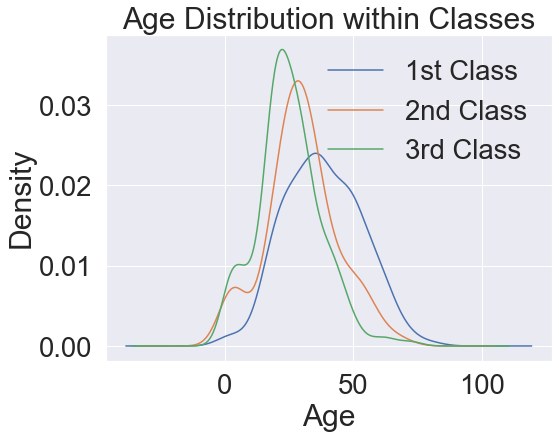

In [39]:
# Age distribution within classes
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass']==1].plot(kind='kde')
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within Classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

* Class가 높을수록 나이 많은 사람의 비중이 커짐.


* 나이대가 변하면서 생존률이 어떻게 되는지 보려고 합니다.
* 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다. 

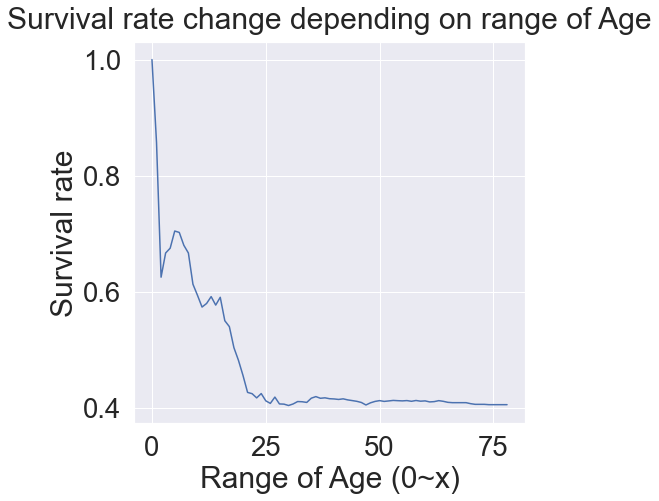

In [40]:
cummulate_survival_ratio = []
for i in range(1,80) : 
    cummulate_survival_ratio.append(df_train[df_train['Age']<i]['Survived'].sum() / len(df_train[df_train['Age']<i]['Survived']))
    # true / (true+false)
    
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age (0~x)')
plt.show()

* 나이가 어릴수록 생존률이 확실히 높음.
* 우리는 나이가 중요한 feature로 쓰일 수 있음을 확인했습니다.

### Pclass, Sex, Age

* 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해서 보고싶습니다. 이를 쉽게 그려주는 것이 seaborn의 `violinplot` 입니다.
* x축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고싶어하는 distribution(Age) 입니다. 


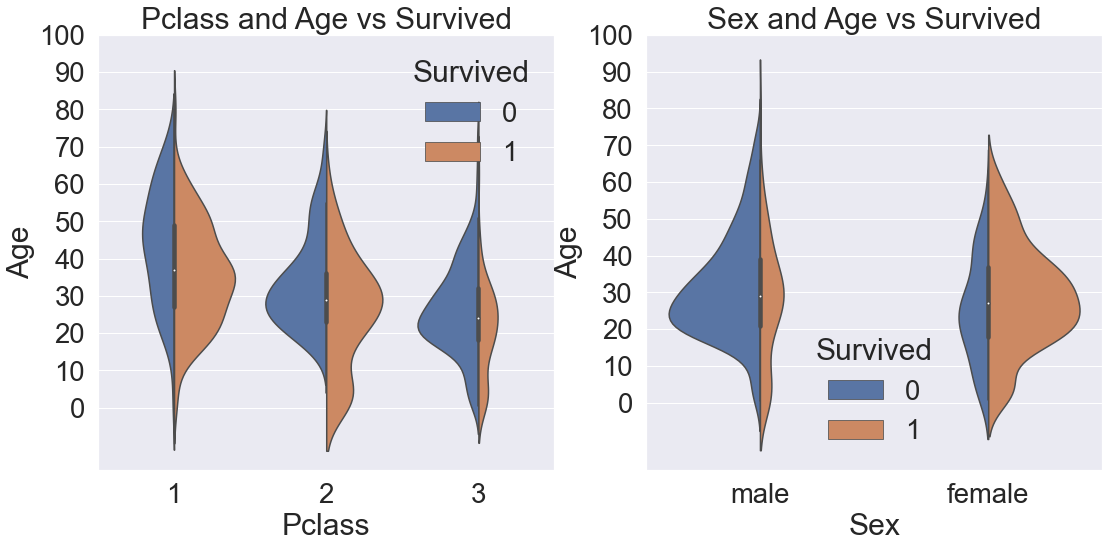

In [44]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age",hue='Survived',data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age",hue="Survived", data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

* 왼쪽 그림은 Pclass별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다. 
* 오른쪽 그림도 마찬가지, Sex 별로 생존에 따른 Age와 Sex의 distribution이 어떻게 다른지 보여주는 그래프입니다. 
* 생존만 봤을 때, 모든 클래스에서 나이가 어릴수록 생존을 많이 한 것을 볼 수 있습니다.
* 오른쪽 그림에서 보면 명확히 여자가 생존을 많이 한 것을 볼 수 있습니다. 
* 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다. 

### Embarked

* 탑승한 항구를 나타냅니다.
* 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

<AxesSubplot:xlabel='Embarked'>

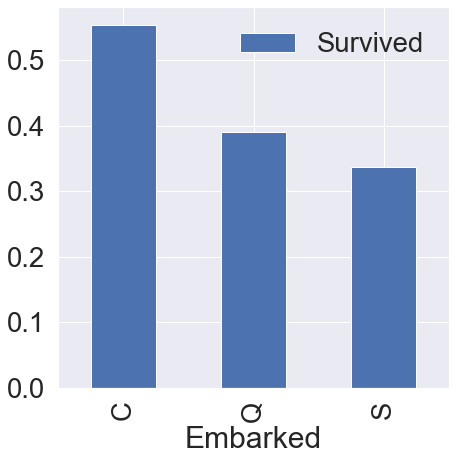

In [46]:
f, ax = plt.subplots(1,1,figsize=(7,7))
df_train[['Embarked','Survived']].groupby(['Embarked'],as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax)

* 조금의 차이는 있지만 생존률은 비슷. 그래도 C가 제일 높음.
* 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠음. -> 사실 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인해볼 수 있습니다. 
* 다른 feature로 split 하여 한번 살펴보겠습니다. 

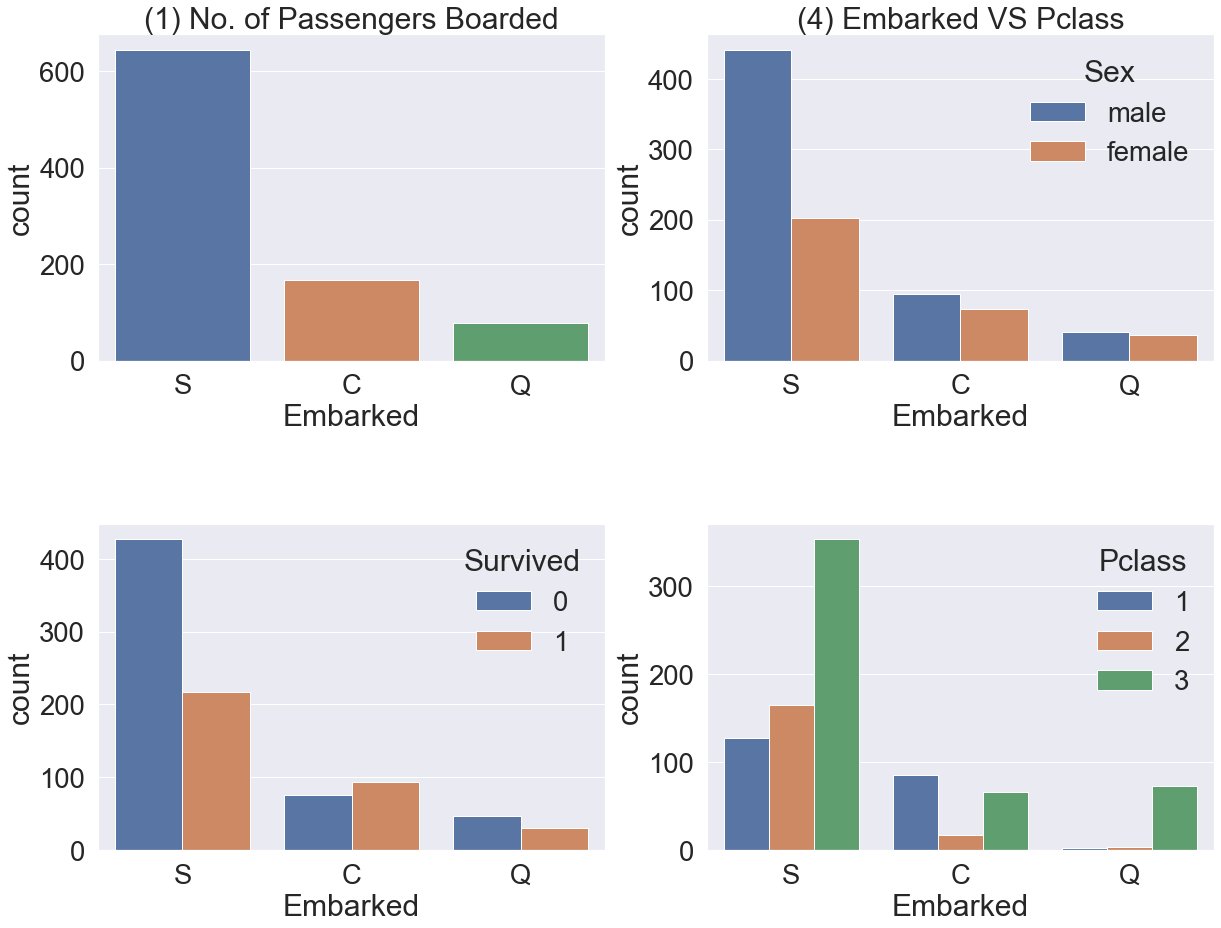

In [50]:
f, ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. of Passengers Boarded')
sns.countplot('Embarked', hue = 'Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue = 'Survived', data=df_train, ax=ax[1,0])
ax[0,1].set_title('(3) Embarked VS Survived')
sns.countplot('Embarked', hue = 'Pclass', data=df_train, ax=ax[1,1])
ax[0,1].set_title('(4) Embarked VS Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 전체적으로 봤을 때, S에서 가자 많은 사람이 탑승했습니다. 
* Figure(2) - C와 Q는 남녀의 비율이 비슷하고, S는 남자가 더 많습니다.
* Figure(3) - 생존 확률이 S의 경우 매우 낮은 것을 알 수 있습니다. 
* Figure(4) - Class로 split해보니, C가 생존확률이 높은 건 클래스가 높은 사람이 많이 타서 그렇습니다. S는 3rd Class가 많아서 생존확률이 낮게 나옵니다. 

### Family - SibSp(형제 자매) + Parch(부모,자녀)

* SibSp와 Parch를 합하면 Family가 될 것입니다. Family로 합쳐서 분석해봅시다. 

In [51]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] +1 #자기 자신 포함 (+1)
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] +1

In [52]:
print("Maximum size of Family :",df_train['FamilySize'].max())
print("Minimum size of Family :",df_train['FamilySize'].min())

Maximum size of Family : 11
Minimum size of Family : 1


* FamilySize와 생존의 관계를 한번 살펴봅시다. 

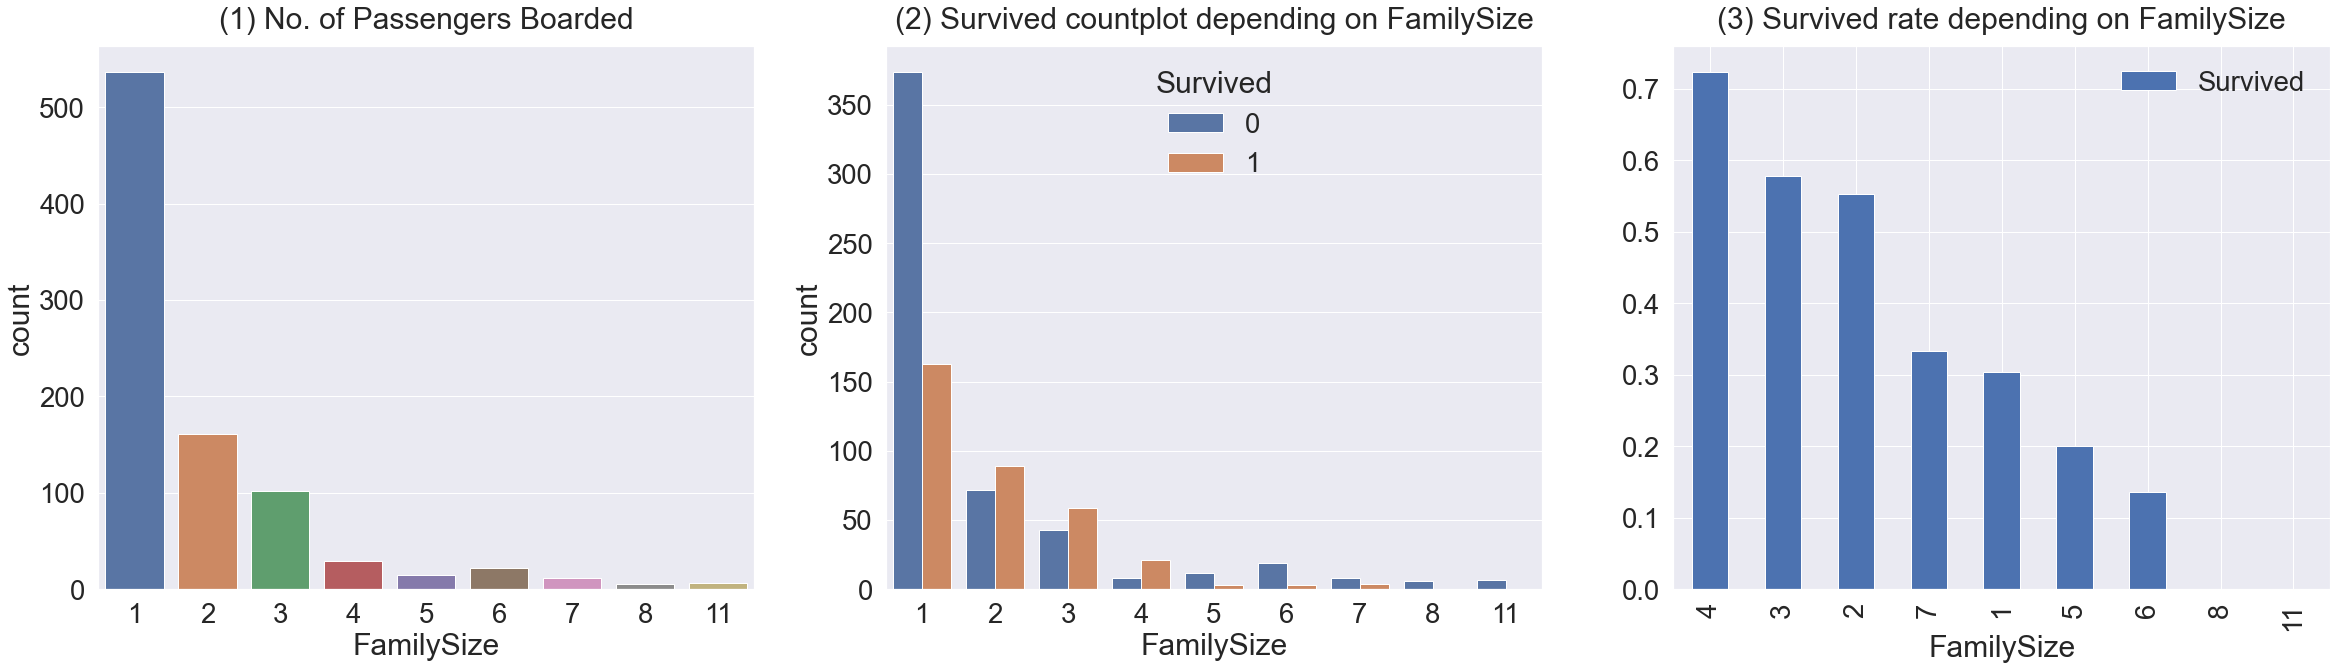

In [58]:
f, ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

df_train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

* Figure(1) - 가족크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고 그 다음으로 2,3,4명입니다. 
* Figure(2),(3) - 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 너무 많아질수록(5,6,7,8,11) 생존확률이 낮아지네요. 가족수가 너무 작어도(1), 너무 커도(5,6,8,11) 생존 확률이 작네요. 3~$명 선에서 생존 확률이 높은걸 확인할 수 있습니다. 

### Fare

* Fare는 탑승요금이며, continuous feature 입니다. 한번 histogram을 그려보겠습니다. 

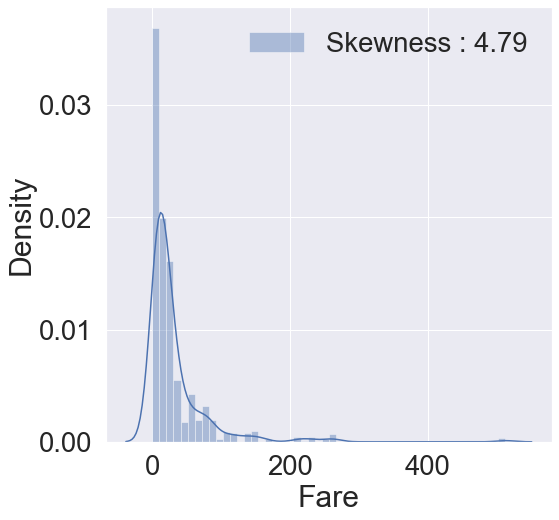

In [61]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g.legend(loc='best')

* distribution이 매우 비대칭인 것을 알 수 있습니다. (high skewness). 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있습니다. 몇개 없는 outlier에 대해서 너무 민감하게 반응한다면 실제 예측 시에 좋지 못한 결과를 부를 수 있습니다.
* outlier의 영향을 줄이기 위해 Fare에 log를 취하겠습니다.
* 여기서 우리는 pandas의 유용한 기능을 사용할 겁니다. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고싶으면 아래의 `map`, 또는 `apply`를 사용하면 매우 손쉽게 적용할 수 있습니다. 
* 우리가 지금 원하는 것은 Fare columns의 데이터 모두를 log값 취하는 것인데, 파이썬의 `lamda` 함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 됩니다. 

In [67]:
df_train['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

In [68]:
# testset에 있는 nan value를 평균값으로 치환
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()

# 탑승 요금은 1 이하일 수 없으니까(?) else 0 써준듯.
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

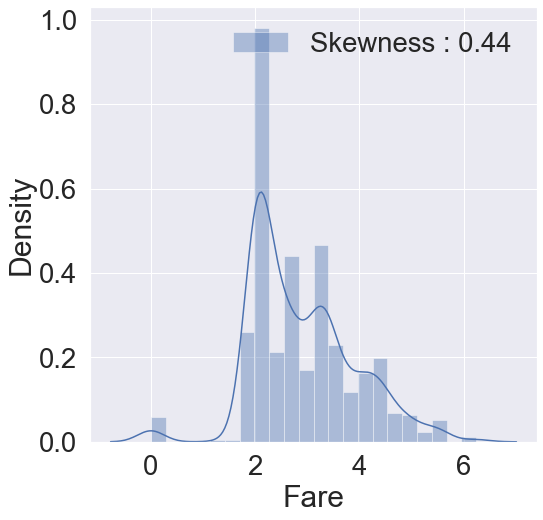

In [69]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g.legend(loc='best')

* log를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
* 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
* 사실 방금한 것은 feature engineering에 들어가는 부분인데, 여기서 작업해'ㅆ습니다. 
* 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering이라고 하는데, 우리는 이제 그것을 살펴볼 것입니다. 

### Cabin

* 이 feature는 NaN이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않습니다.
* 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

In [70]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


### Ticket

* 이 feature는 NaN은 없습니다. 일단 string data이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다. 

In [71]:
df_train['Ticket'].value_counts()

347082        7
CA. 2343      7
1601          7
CA 2144       6
3101295       6
             ..
C.A. 29178    1
2662          1
A/S 2816      1
230434        1
315089        1
Name: Ticket, Length: 681, dtype: int64

* 보시다시피, ticket number 는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
* 여러분이 직접 한번 아이디어를 내보세요! 이것이 본격적인 캐글 레이스의 시작점입니다 ^^
* 이 튜토리얼에서는 튜토리얼이니 일단 ticket 은 넘기도록 하겠습니다. 튜토리얼을 끝낸 후, 여러분의 모델의 성능을 향상시키기 위해 ticket 에서 정보를 이끌어내는 것도 좋겠네요!

* 본 튜토리얼은 https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python, https://www.kaggle.com/startupsci/titanic-data-science-solutions, https://www.kaggle.com/ash316/eda-to-prediction-dietanic, https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 을 참고하여 만들었습니다. 공유해준 캐글러께 감사드립니다.